In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from statsmodels.stats.proportion import proportions_ztest
from sklearn.feature_selection import chi2

In [2]:
sensor_usage = pd.read_csv('../[All]Sensor_Usage_without_authors.csv')

In [3]:
# Read the file getting from Euphony
with open('/Volumes/SeagateExp/proposed.json') as f:  # This file is too large to be uploaded to github, so you can start from cell 8.
    malwares = json.load(f)

In [4]:
# Label the apps: 1 -- Malware; 0 -- Benign App
labels = []
for sha256 in sensor_usage['SHA256'].values:
    if malwares.get(sha256.lower()) != None:
        labels.append(1)
    else:
        labels.append(0)  

sensor_usage['Malware'] = labels

In [5]:
print('Number of Original Benign Apps:', sensor_usage[sensor_usage['Category'] == 'Original']['Malware'].value_counts()[0])
print('Number of Original Malware:', sensor_usage[sensor_usage['Category'] == 'Original'].shape[0] - sensor_usage[sensor_usage['Category'] == 'Original']['Malware'].value_counts()[0])

Number of Original Benign Apps: 2779
Number of Original Malware: 0


In [6]:
print('Number of Repackaged Benign Apps:', sensor_usage[sensor_usage['Category'] == 'Repackaged']['Malware'].value_counts()[0])
print('Number of Repackaged Malware:', sensor_usage[sensor_usage['Category'] == 'Repackaged'].shape[0] - sensor_usage[sensor_usage['Category'] == 'Repackaged']['Malware'].value_counts()[0])

Number of Repackaged Benign Apps: 4190
Number of Repackaged Malware: 11108


In [7]:
sensor_usage.to_csv('Sensor_Usage_w_Label.csv', index = False)

In [8]:
sensor_usage = pd.read_csv('Sensor_Usage_w_Label.csv')

### How many malware and benign apps?

In [9]:
print("Number of Malware:", sensor_usage['Malware'].value_counts()[1], ';', 
      "Number of Benign Apps:", sensor_usage['Malware'].value_counts()[0])

Number of Malware: 11108 ; Number of Benign Apps: 6969


### How many apps using sensors in each of the two catogiries, malware and benign apps? (Percentage)

In [10]:
sensor_usage['Number of Sensor Types'] = sensor_usage.drop(['SHA256', 'Category', 'Malware'], axis = 1).sum(axis = 1)
sensor_usage['Using Sensors'] = sensor_usage['Number of Sensor Types'] > 0

Text(0.5, 1.0, 'Distribution of Number of Sensor Types Used By An App')

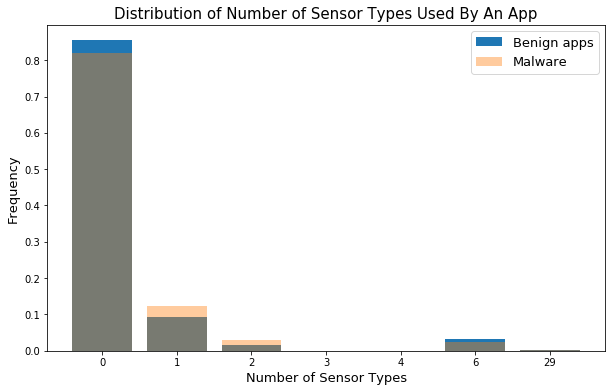

In [11]:
benign_sensor_distribution = (sensor_usage[sensor_usage['Malware'] == 0]['Number of Sensor Types'].value_counts()/sensor_usage[sensor_usage['Malware'] == 0].shape[0]).sort_index()
malware_sensor_distribution = (sensor_usage[sensor_usage['Malware'] == 1]['Number of Sensor Types'].value_counts()/sensor_usage[sensor_usage['Malware'] == 1].shape[0]).sort_index()
x_benign = [str(cnt) for cnt in benign_sensor_distribution.index.to_list()]
x_malware = [str(cnt) for cnt in malware_sensor_distribution.index.to_list()]
plt.figure(figsize = (10, 6))
plt.bar(x_benign, benign_sensor_distribution.values, label = 'Benign apps')
plt.bar(x_malware, malware_sensor_distribution.values, alpha = 0.4, label = 'Malware')
plt.xlabel('Number of Sensor Types', fontsize = 13)
plt.ylabel('Frequency', fontsize = 13)
plt.legend(fontsize = 13)
plt.title('Distribution of Number of Sensor Types Used By An App', fontsize = 15)


In [12]:
benign_if_use_sensor = sensor_usage[sensor_usage['Malware'] == 0]['Using Sensors'].value_counts() / sensor_usage[sensor_usage['Malware'] == 0].shape[0]
malware_if_use_sensor = sensor_usage[sensor_usage['Malware'] == 1]['Using Sensors'].value_counts() / sensor_usage[sensor_usage['Malware'] == 1].shape[0]

Text(0.5, 1.0, 'Percentage of Apps Using Sensors & Not Using Senors')

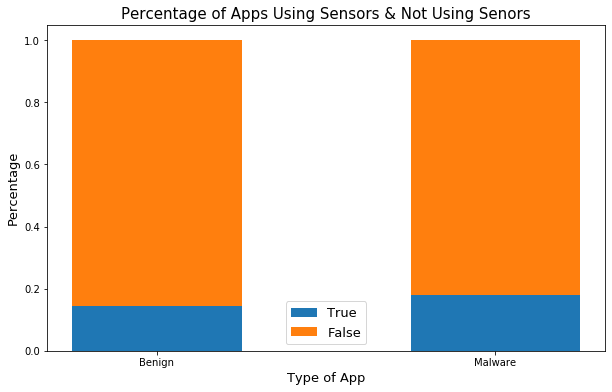

In [13]:
if_use_sensor = pd.DataFrame({'Benign': benign_if_use_sensor, 'Malware': malware_if_use_sensor}).T
plt.figure(figsize = (10, 6))
plt.bar(if_use_sensor.index, if_use_sensor[True].values, width = 0.5, label = 'True')
plt.bar(if_use_sensor.index, if_use_sensor[False].values, bottom=if_use_sensor[True].values, width = 0.5, label = 'False')

plt.xlabel('Type of App', fontsize = 13)
plt.ylabel('Percentage', fontsize = 13)
plt.legend(fontsize = 13)
plt.title('Percentage of Apps Using Sensors & Not Using Senors', fontsize = 15)

In [14]:
# Do statistical test
# Null hypothesis: # sensor types used by malware <= # sensor types used by original apps
# Alternative hypothesis: # sensor types used by malware > # sensor types used by original apps

significance = 0.05

sample_success_a, sample_size_a = (sensor_usage[sensor_usage['Malware'] == 0]['Using Sensors'].value_counts().values[1], sensor_usage[sensor_usage['Malware'] == 0].shape[0])
sample_success_b, sample_size_b = (sensor_usage[sensor_usage['Malware'] == 1]['Using Sensors'].value_counts().values[1], sensor_usage[sensor_usage['Malware'] == 1].shape[0])

successes = np.array([sample_success_a, sample_success_b])
samples = np.array([sample_size_a, sample_size_b])

stat, p_value = proportions_ztest(count = successes, nobs = samples, alternative = 'smaller')

print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))
if p_value > significance:
    print ("Fail to reject the null hypothesis")
else:
    print ("Reject the null hypothesis. The number of sensor types used by malware is statistically significant larger than that of original apps.")

z_stat: -6.155, p_value: 0.000
Reject the null hypothesis. The number of sensor types used by malware is statistically significant larger than that of original apps.


### Difference between Sensor combinations of each category

In [15]:
int_sensor = {1: 'accelerometer', 35: 'accelerometer_uncalibrated', -1: 'all', 
              13: 'ambient_temperature', 65536: 'device_private_base', 15: 'game_rotation_vector', 
              20: 'geomagnetic_rotation_vector', 9: 'gravity', 4: 'gyroscope', 16: 'gyroscope_uncalibrated', 
              31: 'heart_beat', 21: 'heart_rate', 36: 'hinge_angle', 5: 'light', 10: 'linear_acceleration', 
              34: 'low_latency_offbody_detect', 2: 'magnetic_field', 14: 'magnetic_field_uncalibrated', 
              30: 'motion_detect', 3: 'orientation', 28: 'pose_6dof', 6: 'pressure', 8: 'proximity', 
              12: 'relative_humidity', 11: 'rotation_vector', 17: 'significant_motion', 29: 'stationary_detect', 
              19: 'step_counter', 18: 'step_detector', 7: 'temperature'}

In [16]:
sensor_int = {val: key for key, val in int_sensor.items()}

In [17]:
X = sensor_usage.drop(['SHA256', 'Category', 'Malware'], axis = 1)
X.columns = [str(sensor_int.get(t)) for t in X.drop(['Number of Sensor Types', 'Using Sensors'], axis = 1).columns.to_list()] + ['Number of Sensor Types', 'Using Sensors']


In [18]:
combinations = []
for i in X.index:
    combination = ''
    for f in X.drop(['Number of Sensor Types', 'Using Sensors'], axis = 1).columns:
        if X.iloc[i][f] > 0:
            combination += f + ','
    combination = combination.strip(',')
    combinations.append(combination)

In [19]:
sensor_usage['Combination'] = combinations

In [20]:
benign_combination_df = (sensor_usage[sensor_usage['Malware'] == 0]['Combination'].value_counts()[1:]/sensor_usage[(sensor_usage['Malware'] == 0) & (sensor_usage['Using Sensors'] == True)].shape[0]).to_frame().reset_index()
malware_combination_df = (sensor_usage[sensor_usage['Malware'] == 1]['Combination'].value_counts()[1:]/sensor_usage[(sensor_usage['Malware'] == 1) & (sensor_usage['Using Sensors'] == True)].shape[0]).to_frame().reset_index()
combination_df = benign_combination_df.merge(malware_combination_df, on = 'index', how = 'left')
combination_df.columns = ['Combination', 'Percentage_Benign', 'Percentage_Malware']
combination_df = combination_df.fillna(0)

Text(0.5, 1.0, 'Distribution of Combination of Sensor Types Used By An App')

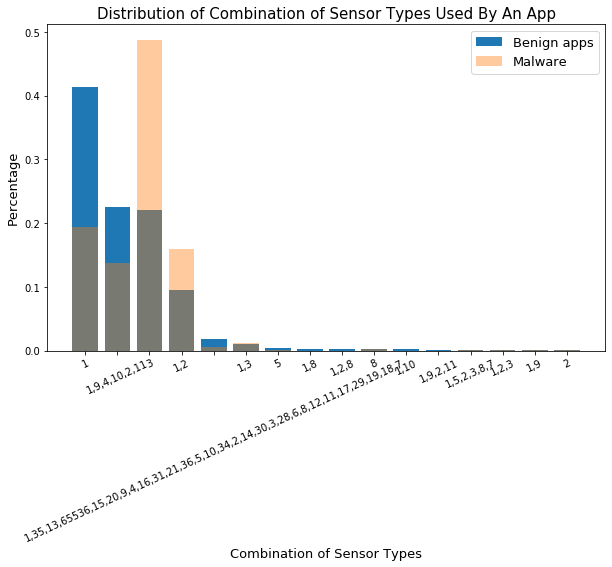

In [21]:
plt.figure(figsize = (10, 6))
plt.bar(combination_df['Combination'], combination_df['Percentage_Benign'], label = 'Benign apps')
plt.bar(combination_df['Combination'], combination_df['Percentage_Malware'], alpha = 0.4, label = 'Malware')
plt.xlabel('Combination of Sensor Types', fontsize = 13)
plt.ylabel('Percentage', fontsize = 13)
plt.xticks(rotation = 25)
plt.legend(fontsize = 13)
plt.title('Distribution of Combination of Sensor Types Used By An App', fontsize = 15)

### Correlation of sensor one-hot features with target

In [22]:
# One-hot encode feature `Combiantion`
sensor_usage = sensor_usage.join(pd.get_dummies(sensor_usage['Combination'], prefix='Combination')).drop(['Combination', 'Combination_'], axis = 1)

In [23]:
X = sensor_usage.drop(['SHA256', 'Category', 'Malware'], axis = 1)
y = sensor_usage['Malware']

In [24]:
chi_2, p = chi2(X, y)

Text(0.5, 1.0, 'P-values of Chi2 Test')

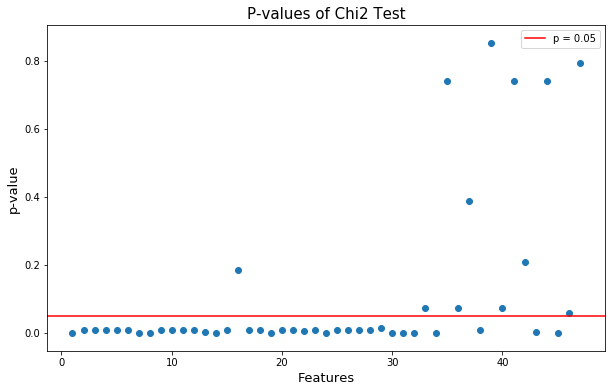

In [25]:
plt.figure(figsize = (10, 6))
plt.scatter(np.arange(1, 1+X.shape[1]), p)
plt.axhline(y = 0.05, color = 'r', linestyle = '-', label = 'p = 0.05')
plt.xlabel('Features', fontsize = 13)
plt.ylabel('p-value', fontsize = 13)
plt.legend()
plt.title('P-values of Chi2 Test', fontsize = 15)

In [26]:
print('The features not correlated with target are:',  X.iloc[:, p > 0.05].columns.to_list())

The features not correlated with target are: ['magnetic_field', 'Combination_1,10', 'Combination_1,2,3', 'Combination_1,2,8', 'Combination_1,3', 'Combination_1,5,2,3,8,7', 'Combination_1,8', 'Combination_1,9', 'Combination_1,9,2,11', 'Combination_2', 'Combination_5', 'Combination_8']
